In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib as matplotlib
import matplotlib.pyplot as plt

import statsmodels.api as sm

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ShuffleSplit, GroupKFold, cross_validate, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, lasso_path
from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor

from xgboost import XGBRegressor

pd.options.mode.chained_assignment = None  # default='warn'
%load_ext autoreload
%autoreload 2

In [3]:
from utils import REPO_PATH, DATA_PATH, DATA_CLEAN_PATH
from utils import set_plt_settings
from train_functions import scoring_default, run_cv

set_plt_settings()

## Make analytic datasets

In [4]:
df = pd.read_csv(DATA_CLEAN_PATH / 'analysis_df.csv')

X = df.loc[:, [col for col in df.columns if col.startswith(('ndvi', 'lst'))]]
y = (df.total / df.area_km).to_numpy() # short tons per km^2
g_state = df.statefp

## Regress on all features

In [5]:
scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
scaler.fit(X)
X_scaled = pd.DataFrame(scaler.transform(X), columns=X.columns)

In [10]:
X_lm = sm.add_constant(X_scaled, prepend=False)
lm = sm.OLS(endog=y, exog=X_lm, hasconst=True)
res = lm.fit()
print(res.summary().as_latex())

\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:}               &        y         & \textbf{  R-squared:         } &     0.798   \\
\textbf{Model:}                       &       OLS        & \textbf{  Adj. R-squared:    } &     0.797   \\
\textbf{Method:}                      &  Least Squares   & \textbf{  F-statistic:       } &     1180.   \\
\textbf{Date:}                        & Sat, 04 Jun 2022 & \textbf{  Prob (F-statistic):} &     0.00    \\
\textbf{Time:}                        &     20:56:18     & \textbf{  Log-Likelihood:    } &   -75591.   \\
\textbf{No. Observations:}            &        8400      & \textbf{  AIC:               } & 1.512e+05   \\
\textbf{Df Residuals:}                &        8371      & \textbf{  BIC:               } & 1.514e+05   \\
\textbf{Df Model:}                    &          28      & \textbf{                     } &             \\
\textbf{Covariance Type:}             &    nonrobust     & \textbf{                     } &       

## Run lasso to identify mvp features

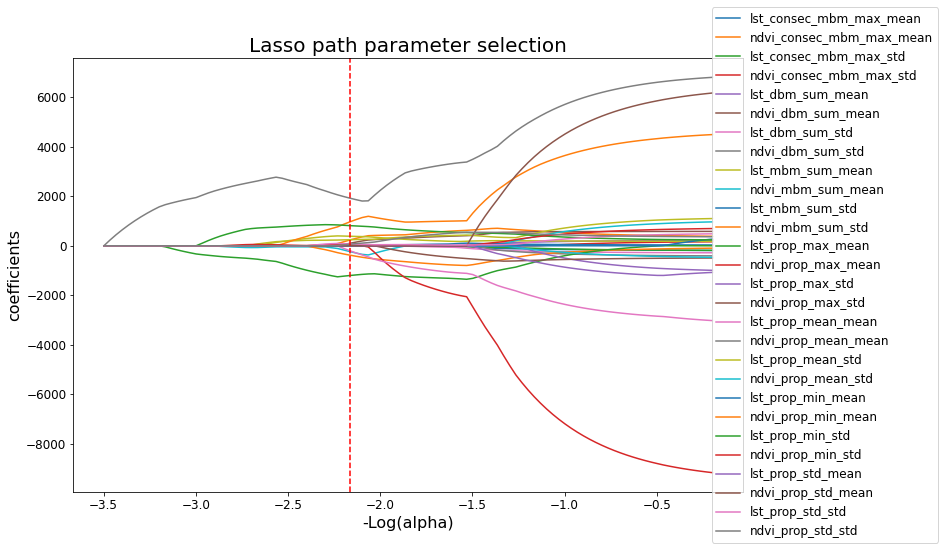

In [11]:
eps = 5e-4  # the smaller it is the longer is the path
a_step = 40
alphas_lasso, coefs_lasso, _ = lasso_path(X_scaled, y, eps=eps)
# Display results
fig, ax = plt.subplots(figsize=(12, 8))
varnames = X_scaled.columns
neg_log_alphas_lasso = -np.log10(alphas_lasso)
for coef_l, v in zip(coefs_lasso, varnames):
    l1 = plt.plot(neg_log_alphas_lasso, coef_l, label=v)

plt.xlabel("-Log(alpha)")
plt.ylabel("coefficients")

plt.legend(loc='right', bbox_to_anchor=(1.3, .5))
plt.axis("tight")
plt.axvline(x=neg_log_alphas_lasso[a_step], color='r', linestyle='--')
plt.savefig(REPO_PATH / 'results/fig_lasso.png', bbox_inches='tight')

plt.title("Lasso path parameter selection")
plt.show()

In [12]:
# can we improve regression by selecting these top variables?
top_n = 6
keepcols = varnames[np.argsort(np.abs(coefs_lasso[:, a_step]))[0:top_n]].to_numpy()
print(f'{top_n} most significant variables at alpha {neg_log_alphas_lasso[a_step]}:\n', keepcols)

6 most significant variables at alpha -2.164368077648715:
 ['lst_consec_mbm_max_mean' 'ndvi_prop_std_mean' 'lst_prop_std_mean'
 'lst_prop_min_mean' 'ndvi_prop_mean_std' 'ndvi_prop_max_std']


In [13]:
X_scaled_lasso = X_scaled.loc[:, keepcols]
X_lm = sm.add_constant(X_scaled_lasso, prepend=False)
lm = sm.OLS(endog=y, exog=X_lm, hasconst=True)
res = lm.fit()
print(res.summary().as_latex())

\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:}              &        y         & \textbf{  R-squared:         } &     0.602   \\
\textbf{Model:}                      &       OLS        & \textbf{  Adj. R-squared:    } &     0.601   \\
\textbf{Method:}                     &  Least Squares   & \textbf{  F-statistic:       } &     2113.   \\
\textbf{Date:}                       & Sat, 04 Jun 2022 & \textbf{  Prob (F-statistic):} &     0.00    \\
\textbf{Time:}                       &     20:56:45     & \textbf{  Log-Likelihood:    } &   -78440.   \\
\textbf{No. Observations:}           &        8400      & \textbf{  AIC:               } & 1.569e+05   \\
\textbf{Df Residuals:}               &        8393      & \textbf{  BIC:               } & 1.569e+05   \\
\textbf{Df Model:}                   &           6      & \textbf{                     } &             \\
\textbf{Covariance Type:}            &    nonrobust     & \textbf{                     } &             \\
